# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Contributors: Ryan Janssen, Filip Michalsky

Enrollment Status (109A, 121A, 209A, or E109A): 209A

Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from scipy.stats import zscore
%matplotlib inline

# In this problem set, we are often iterating with small Lambda values that cause many warnings to appear. 
# So, we'll turn off warnings for this set:
import warnings
warnings.filterwarnings('ignore')

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

Data Source: https://www.capitalbikeshare.com/system-data

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [3]:
# Importing processed data from HW3:
test = pd.read_csv("df_test.csv", index_col=0)
train = pd.read_csv("df_train.csv", index_col=0)

x_train = train.drop('count', axis=1)
y_train = train['count']

x_test = test.drop('count', axis=1)
y_test = test['count']

## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [4]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [5]:
# Fit ridge/lasso regressions to training set
alphas = np.logspace(-5,5, 11)

ridge = RidgeCV(alphas = alphas, fit_intercept=True, normalize=False)
ridge.fit(x_train, y_train)

lasso = LassoCV(alphas = alphas, fit_intercept=True, normalize=False)
lasso.fit(x_train, y_train)

# Get our linear regression parameters from HW3:
models_coefs = pd.read_csv("linear_params.csv",header = None, index_col=0).drop(['const'])
models_coefs.columns = ['Linear Regression']
models_coefs['Ridge Regression'] = ridge.coef_
models_coefs['Lasso Regression'] = lasso.coef_

# Compare parameters
print(models_coefs)

                 Linear Regression  Ridge Regression  Lasso Regression
0                                                                     
holiday                -616.602710       -235.816851       -166.795792
workingday              -24.093294         30.405330          0.000000
temp                     82.710082        577.535711        597.898736
atemp                    31.460512        505.976639        455.895075
humidity                -38.263065       -521.713443       -524.701211
windspeed             -3260.749571       -254.076449       -238.712482
season_1.0            -1226.186543       -760.122961       -976.436154
season_2.0             -327.357503        -46.004440         -0.000000
season_3.0             -193.304968       -202.530657       -200.038590
month_1.0               118.835819       -268.604545       -107.298984
month_2.0               207.775911       -122.729934         -0.000000
month_3.0               358.016717         47.757061         11.078012
month_

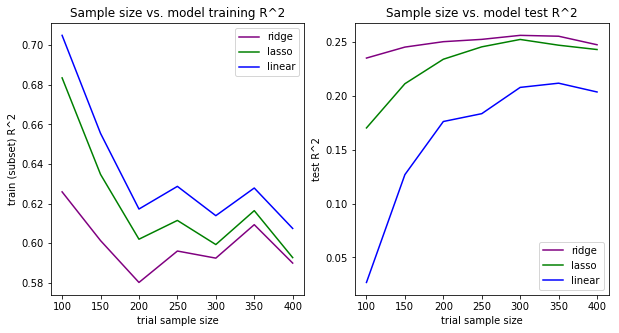

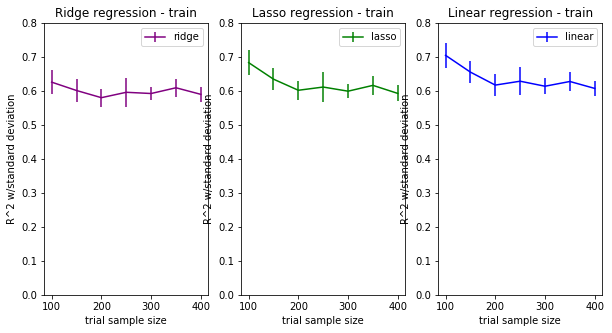

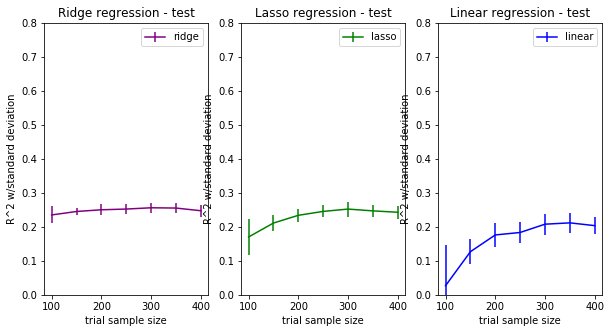

In [6]:
#alphas = np.logspace(-5,5, 11)
alphas = [10.0]

ridge = RidgeCV(alphas = alphas, fit_intercept=True, normalize=False)
lasso = LassoCV(alphas = alphas, fit_intercept=True, normalize=False)
linear = LinearRegression(fit_intercept=True)

ridge_subset_r2s, ridge_test_r2s, ridge_subset_stds, ridge_test_stds = [], [], [], []
lasso_subset_r2s, lasso_test_r2s, lasso_subset_stds, lasso_test_stds = [], [], [], []
linear_subset_r2s, linear_test_r2s, linear_subset_stds, linear_test_stds = [], [], [], []

trial_sizes = range(100, 450, 50)

for k in trial_sizes:
    this_k_ridge_subset_r2s = []
    this_k_ridge_test_r2s = []
    
    this_k_lasso_subset_r2s = []
    this_k_lasso_test_r2s = []
    
    this_k_linear_subset_r2s = []
    this_k_linear_test_r2s = []
    
    for trial in range(10):
        x_subset, y_subset = sample(x_train.values, y_train.values, k)
        
        ridge.fit(x_subset, y_subset)
        lasso.fit(x_subset, y_subset)
        linear.fit(x_subset, y_subset)

        this_k_ridge_subset_r2s.append(ridge.score(x_subset, y_subset))
        this_k_ridge_test_r2s.append(ridge.score(x_test, y_test))
        
        this_k_lasso_subset_r2s.append(lasso.score(x_subset, y_subset))
        this_k_lasso_test_r2s.append(lasso.score(x_test, y_test))
        
        this_k_linear_subset_r2s.append(linear.score(x_subset, y_subset))
        this_k_linear_test_r2s.append(linear.score(x_test, y_test))
    
    ridge_subset_r2s.append(np.array(this_k_ridge_subset_r2s).mean())
    ridge_test_r2s.append(np.array(this_k_ridge_test_r2s).mean())
    ridge_subset_stds.append(np.array(this_k_ridge_subset_r2s).std())
    ridge_test_stds.append(np.array(this_k_ridge_test_r2s).std())
    
    lasso_subset_r2s.append(np.array(this_k_lasso_subset_r2s).mean())
    lasso_test_r2s.append(np.array(this_k_lasso_test_r2s).mean())
    lasso_subset_stds.append(np.array(this_k_lasso_subset_r2s).std())
    lasso_test_stds.append(np.array(this_k_lasso_test_r2s).std())
    
    linear_subset_r2s.append(np.array(this_k_linear_subset_r2s).mean())
    linear_test_r2s.append(np.array(this_k_linear_test_r2s).mean())
    linear_subset_stds.append(np.array(this_k_linear_subset_r2s).std())
    linear_test_stds.append(np.array(this_k_linear_test_r2s).std())
    
    

fig1 = plt.figure(figsize=(10,5))
fig1.tight_layout
ax1 = fig1.add_subplot(121)
ax1.plot(trial_sizes, ridge_subset_r2s, label = "ridge", color = 'purple')
ax1.plot(trial_sizes, lasso_subset_r2s, label = "lasso", color='green')
ax1.plot(trial_sizes, linear_subset_r2s, label = "linear", color = 'blue')
ax1.set_title("Sample size vs. model training R^2")
ax1.set_xlabel("trial sample size")
ax1.set_ylabel("train (subset) R^2")
ax1.legend()

ax2 = fig1.add_subplot(122)
ax2.plot(trial_sizes, ridge_test_r2s, label = "ridge", color='purple')
ax2.plot(trial_sizes, lasso_test_r2s, label = "lasso", color='green')
ax2.plot(trial_sizes, linear_test_r2s, label = "linear", color = 'blue')
ax2.set_title("Sample size vs. model test R^2")
ax2.set_xlabel("trial sample size")
ax2.set_ylabel("test R^2")
ax2.legend()

fig2 = plt.figure(figsize=(10,5))
fig2.tight_layout
ax3 = fig2.add_subplot(131)
ax4 = fig2.add_subplot(132)
ax5 = fig2.add_subplot(133)
ax3.errorbar(trial_sizes, ridge_subset_r2s, yerr=ridge_subset_stds, label = "ridge", color='purple')
ax4.errorbar(trial_sizes, lasso_subset_r2s, lasso_subset_stds, label = "lasso", color='green')
ax5.errorbar(trial_sizes, linear_subset_r2s, linear_subset_stds, label = "linear", color = 'blue')

ax3.set_title("Ridge regression - train")
ax3.set_xlabel("trial sample size")
ax3.set_ylabel("R^2 w/standard deviation")
ax3.set_ylim(0,0.8)
ax3.legend()

ax4.set_title("Lasso regression - train")
ax4.set_xlabel("trial sample size")
ax4.set_ylabel("R^2 w/standard deviation")
ax4.set_ylim(0,0.8)
ax4.legend()

ax5.set_title("Linear regression - train")
ax5.set_xlabel("trial sample size")
ax5.set_ylabel("R^2 w/standard deviation")
ax5.set_ylim(0,0.8)
ax5.legend()

fig3 = plt.figure(figsize=(10,5))
fig3.tight_layout
ax6 = fig3.add_subplot(131)
ax7 = fig3.add_subplot(132)
ax8 = fig3.add_subplot(133)
ax6.errorbar(trial_sizes, ridge_test_r2s, ridge_test_stds, label = "ridge", color='purple')
ax7.errorbar(trial_sizes, lasso_test_r2s, lasso_test_stds, label = "lasso", color='green')
ax8.errorbar(trial_sizes, linear_test_r2s, linear_test_stds, label = "linear", color = 'blue')

ax6.set_title("Ridge regression - test")
ax6.set_xlabel("trial sample size")
ax6.set_ylabel("R^2 w/standard deviation")
ax6.set_ylim(0,0.8)
ax6.legend()

ax7.set_title("Lasso regression - test")
ax7.set_xlabel("trial sample size")
ax7.set_ylabel("R^2 w/standard deviation")
ax7.set_ylim(0,0.8)
ax7.legend()

ax8.set_title("Linear regression - test")
ax8.set_xlabel("trial sample size")
ax8.set_ylabel("R^2 w/standard deviation")
ax8.set_ylim(0,0.8)
ax8.legend()

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.

** As we can see above, the larger coefficients from the linear regression are shrunk in both the Ridge and Lasso regressions.  And the smaller coefficients from the linear regression are larger for the Ridge/Lasso.**
** The two shrinkage methods differ in that Lasso shrinks several coefficients to zero, whereas ridge doesn't shrink any coefficients to zero.**


- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?

** The Ridge coefficients never shrink to "close to zero" under these parameters.  The Lasso coefficients [workingday, season_2.0, month_2.0, month_5.0, day_of_week_4.0, weather_2.0] all shrink to zero. **

** These were generally highly correlated coefficients from HW3 (c).  For instance, workingday was correlated with all of the days of the week, and the respective months and seasons were correlated. **

- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

** For certain values of alpha, Lasso will assign temp a 0 coefficient, while Ridge will never do this.  This is because Lasso is built to zero out certain redundant coefficients and there is a high degree of correlation between temp and atemp. **

** Interestingly, though, for most alphas (including the selected alpha above), even the Lasso regression will keep both temp and atemp.  We believe this is because temp/atemp is some of the stronger predictors of count. **


- How do the training and test  R2R2  scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated  R2R2  change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

** The training R^2 is generally decreasing with sample size for all 3 regressions, and the test R^2 is generally increasing for all 3 regressions.  This is not surprising, since a larger training sample will help us to reduce overfitting.  **

** Furthermore, the ridge regression generally performs the best on the test set, and the worst on the training set.  We believe this is because the ridge model is a good balance between removing the higher-order predictors while still not "zeroing" out information as the lasso regression does. **

** Confidence intervals tend to generally decrease with increasing trial size (aka the train set size). Additionally, the Ridge regression seems to have the tightest confidence intervals.  **

** For small sample sizes, ridge gains a bigger "advantage" on the test R^2 and a bigger "disadvantage" on the training R^2.  Because our priority is maximizing out-of-sample predictive power, the best model for low sample sizes is using ridge regression. We believe this happens because ridge regression is effective for reducing collinearity.  In smaller sample sizes, it's more difficult to separate the collinearity from the features, so ridge regression is useful here. **

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [6]:
def add_poly_terms(x, selected_features, deg = 4):
    """
    Adds polynomial terms of order deg, into ONLY selected_features.
    Note that it does not include any interaction terms between the predictors as requested above.
    """
    poly_fit = PolynomialFeatures(degree = deg, include_bias=False)
    x_selected = x.copy()[selected_features]
    
    x_out = x.drop(selected_features, axis = 1)
    # Add each higher order term (doing these individually so we don't get interaction terms)
    for i,feature in enumerate(selected_features):
        for this_deg in range(deg):
            poly_features = poly_fit.fit_transform(x_selected[feature].values.reshape(-1,1))
            x_out[feature+"_deg_"+str(this_deg+1)] = poly_features[:,this_deg]
    return x_out


continuous_predictors = ['temp', 'atemp', 'humidity', 'windspeed']
x_train_poly = add_poly_terms(x_train, continuous_predictors, deg = 4)
x_test_poly = add_poly_terms(x_test, continuous_predictors, deg = 4)
    
poly_ols = sm.OLS(y_train, sm.add_constant(x_train_poly))
poly_ols_fit = poly_ols.fit()
poly_ols_r2 = r2_score(y_test, poly_ols_fit.predict(sm.add_constant(x_test_poly)))
print("Polynomial regression train R^2 =", r2_score(y_train, poly_ols_fit.predict(sm.add_constant(x_train_poly))),"\n")
print("Polynomial regression test R^2 =", r2_score(y_test, poly_ols_fit.predict(sm.add_constant(x_test_poly))),"\n")

ttest=poly_ols_fit.pvalues
print("Model parameters of significance level > 5%:\n", ttest[ttest.values<0.05])

Polynomial regression train R^2 = 0.669656240221 

Polynomial regression test R^2 = 0.29395929122 

Model parameters of significance level > 5%:
 const              4.568215e-29
season_1.0         1.256241e-03
weather_1.0        5.873124e-19
weather_2.0        2.079013e-22
weather_3.0        4.699390e-02
temp_deg_2         2.740200e-02
humidity_deg_1     2.870343e-05
windspeed_deg_1    2.950904e-03
dtype: float64


- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

** The R^2 when polynomial terms is added increases to 0.29.  (In HW3, the linear model, forward selection, and reverse selection had R^2 = 0.249, 0.274, and 0.273, respectively. **

** Using the t-test, the statistically significant polynomial features are:
** This adds a significant quadratic term for for temperature squared as expected.  We also have significant linear terms for humidity and windspeed in the feature set. **

** This is as expected - for example, in HW3 we hypothesized there is a slightly quadratic reliationship with temperature.  When it gets too hot people stop riding bikes. **



- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [7]:
def copy_and_add_inter(x_train):
    x_train_inter = x_train.copy(deep=True)

    x_train_inter['month_12.0'] = 1 - x_train_inter['month_1.0'] - x_train_inter['month_2.0'] - x_train_inter['month_3.0']- x_train_inter['month_4.0'] - x_train_inter['month_5.0'] - x_train_inter['month_6.0'] - x_train_inter['month_7.0'] - x_train_inter['month_8.0']- x_train_inter['month_9.0']- x_train_inter['month_10.0']- x_train_inter['month_11.0']

 
    x_train_inter['month12-temp'] = x_train_inter['month_12.0'] * x_train_inter['temp']

    x_train_inter['wday1-weather1'] = x_train_inter['workingday'] * x_train_inter['weather_1.0']
    
    return x_train_inter
#x_train.head(30)

x_train_inter = copy_and_add_inter(x_train) 
x_test_inter = copy_and_add_inter(x_test)

inter_ols = sm.OLS(y_train, sm.add_constant(x_train_inter))
inter_ols_fit = inter_ols.fit()

inter_ols_r2_train = r2_score(y_train, inter_ols_fit.predict(sm.add_constant(x_train_inter)))
inter_ols_r2_test = r2_score(y_test, inter_ols_fit.predict(sm.add_constant(x_test_inter)))

print("Multilinear regression R^2 train set =", inter_ols_r2_train,"\n")

print("Multilinear regression R^2 test set =", inter_ols_r2_test,"\n")

ttest1=inter_ols_fit.pvalues
print("Model parameters of significance level > 5%:\n", ttest1[ttest1.values<0.05])

Multilinear regression R^2 train set = 0.58038134848 

Multilinear regression R^2 test set = 0.281208658354 

Model parameters of significance level > 5%:
 const          4.697838e-25
humidity       8.186394e-07
windspeed      8.390803e-04
month_9.0      1.062117e-02
month_10.0     1.080134e-02
weather_1.0    1.321830e-08
weather_2.0    9.157829e-16
dtype: float64


 How does this compare with the  R2
  obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

**The R2 on the test set (~28.1%) is higher than ~24.9% test R2 obtained in HW3. The interaction terms are not significant at a 5% significance level.**

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [8]:
# First, let's generate a polynomial with all of the interation terms (this way, we don't get the higher-order interaction terms)
interaction_poly = PolynomialFeatures(degree = 2, interaction_only = True)

x_train_interaction = pd.DataFrame(interaction_poly.fit_transform(x_train), columns = interaction_poly.get_feature_names(x_train.columns))
x_test_interaction = pd.DataFrame(interaction_poly.fit_transform(x_test), columns = interaction_poly.get_feature_names(x_test.columns))

# Then, add in the polynomial terms used earlier
continuous_predictors = ['temp', 'atemp', 'humidity', 'windspeed']
x_big_train = add_poly_terms(x_train_interaction, continuous_predictors, deg = 4)
x_big_test = add_poly_terms(x_test_interaction, continuous_predictors, deg = 4)

print("Full expanded data set has",x_big_train.shape[1], "columns!")

#print(y_train.shape, sm.add_constant(x_big_train).shape)

big_ols = sm.OLS(y_train, sm.add_constant(x_big_train))
big_ols_fit = big_ols.fit()
big_ols_r2 = r2_score(y_train, big_ols_fit.predict(sm.add_constant(x_big_train)))
print("Our full feature training R^2 =",big_ols_r2)

big_ols_r2 = r2_score(y_test, big_ols_fit.predict(sm.add_constant(x_big_test)))
print("Our full feature test R^2 =",big_ols_r2,"\n")

# Fit PCA
num_comp = 5
pca = PCA(num_comp)
pca.fit(x_big_train)
x_train_pca = pca.transform(x_big_train)
x_test_pca = pca.transform(x_big_test)

print("Generating PCA with",num_comp, "components.\nExplained variance ratio:", pca.explained_variance_ratio_, "\n")

# Fit linear regression over sums of the first n components
lin_reg_model = LinearRegression(fit_intercept=True)
for n in range(1,5+1):
    lin_reg_model.fit(x_train_pca[:,:n], y_train)
    print("Training R^2 of first",n,"PCA components=", r2_score(y_train, lin_reg_model.predict(x_train_pca[:,:n])))
    print("Test R^2 of first",n,"PCA components=", r2_score(y_test, lin_reg_model.predict(x_test_pca[:,:n])))

Full expanded data set has 448 columns!
Our full feature training R^2 = 0.906053600868
Our full feature test R^2 = -10.4829235756 

Generating PCA with 5 components.
Explained variance ratio: [ 0.41154589  0.19490725  0.17272211  0.05007462  0.0463068 ] 

Training R^2 of first 1 PCA components= 0.073931302874
Test R^2 of first 1 PCA components= -0.0864310174361
Training R^2 of first 2 PCA components= 0.160690866918
Test R^2 of first 2 PCA components= 0.00113039693806
Training R^2 of first 3 PCA components= 0.211995591978
Test R^2 of first 3 PCA components= -0.0451288125684
Training R^2 of first 4 PCA components= 0.387740710092
Test R^2 of first 4 PCA components= 0.2185158195
Training R^2 of first 5 PCA components= 0.388482846498
Test R^2 of first 5 PCA components= 0.217224230545


- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

** This design matrix has a total of 452 predictors (and 330 data points).  This is unfeasible for several reasons: **

** First, the model overfits very badly.  The training R^2 is 0.91, but the test set R^2 is less than 0! In fact, we have more features than we do datapoints! **

** Additionally, it's very computationall expensive, in both time and space, to regress and manipulate this many features. **


- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

** The models perform quite poorly in the training set  ($R^{2}<0.3$) for the first 3 components.  The forth component adds a significant amount of predictive power, and the fifth term adds very little. We also see that by the fourth component, c.95% of the variance has been explained.**

** It's unfortunately difficult for us symbolize the meaning of each of the components (we just know they are orthogonal representations of the previous predictors.  But it seems to us that a fair trade-off between computational power and model performance is to choose the first 4 components. **

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

** The training $R^{2}$ is highly non-linear versus the components added.  The model has essentially no out-of-sample predictive power until the fourth principal component, when it becomes 0.22. This reinforces our hypothesis that at least the first four principal components are necessary.  However, our model that uses fewer features (where PCA is not required) still performs better, so we would try to use a non-PCA-based solution with fewer interaction terms (if possible).  **

** In this case, each of the coefficients are the weights of each respective principal component, which itself is an orthogonal representation of the previous features. **

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [9]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [10]:
lin_reg_model = LinearRegression(fit_intercept=True)

# Calculate train RMSLE on current model fit
lin_reg_model.fit(x_train_poly, y_train)
y_hat_train = lin_reg_model.predict(x_train_poly)
y_hat_test = lin_reg_model.predict(x_test_poly)
print("Train RMSLE on linear model fit =", rmsle(y_train, y_hat_train))
print("Test RMSLE on linear model fit =", rmsle(y_test, y_hat_test))
print("")


# Now, let's fit a new set on a revised response variable - specifically, log(y+1)
lin_reg_model.fit(x_train_poly, np.log1p(y_train))
y_hat_logit_train = np.expm1(lin_reg_model.predict(x_train_poly))
y_hat_logit_test = np.expm1(lin_reg_model.predict(x_test_poly))
print("Train RMSLE on RMSLE model fit =", rmsle(y_train, y_hat_logit_train))
print("Test RMSLE on RMSLE model fit =", rmsle(y_test, y_hat_logit_test))

Train RMSLE on linear model fit = 0.311064248991
Test RMSLE on linear model fit = 0.501930165551

Train RMSLE on RMSLE model fit = 0.291235068455
Test RMSLE on RMSLE model fit = 0.51473271484


Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model?

* ** We chose to train a linear model on a new y domain, denoted by $y_{new} = log(y + 1)$.  By applying this domain transformation, our linear model will now minimize MSE in the $y_{new}$ domain, and therefore minimize RMSLE in the original $y$ domain. **

* ** As expected, this improves RMSLE in our training set.  Training RMSLE improves from 0.311 to 0.291.  Our test RMSLE actually results in higher RMSLE, but this does not invalidate our RMSLE fit.  It just means that the model may be now overfitting for RMSLE (while it was overfitting for MSE previously). ** 

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [11]:
ridge1 = RidgeCV(alphas = alphas, fit_intercept=True, normalize=False)
ridge1.fit(x_train, y_train)

R2_init=r2_score(y_test, ridge1.predict(x_test))

print("Test R^2 from Part g)",r2_score(y_test, poly_ols_fit.predict(sm.add_constant(x_test_poly))))
print("Test R^2 from Ridge model with all train points",R2_init)
x_train_trim = x_train_poly.copy(deep = True)
y_train_trim = y_train.copy(deep = True)

#print(y_train_trim.shape)

Ridge_Test_R2s_after_drop = []

stop_constant = float("inf")

for i in range(int(len(y_train_trim)*0.05)):
    ridge_reg_model = RidgeCV(alphas = alphas, fit_intercept=True, normalize=False)
    ridge_reg_model.fit(x_train_trim, y_train_trim)
    
    y_prec_train = ridge_reg_model.predict(x_train_trim)
    y_prec_test = ridge_reg_model.predict(x_test_poly)
    
    #print("Train R-score is", r2_score(y_train_trim,y_prec_train))
    #print("Test R-score is",r2_score(y_test,y_prec_test))
    
    #index of the worst value
    y_worst = np.argmax(np.abs(y_train_trim - y_prec_train))
    #worst value
    worst_error =np.max(np.abs(y_train_trim - y_prec_train))
    
    #print("Dropping the worst y", worst_error, "at the index", y_train_trim.index[y_worst],"\n")
    
    if worst_error < 2600:
        print("BREAK")
        break

    x_train_trim = x_train_trim.drop(x_train_trim.index[y_worst])
    y_train_trim = y_train_trim.drop(y_train_trim.index[y_worst])
    Ridge_Test_R2s_after_drop.append(r2_score(y_test,y_prec_test))
    
print("R^2 after removing ~5% of data points", Ridge_Test_R2s_after_drop[-1])

Test R^2 from Part g) 0.29395929122
Test R^2 from Ridge model with all train points 0.274049501816
R^2 after removing ~5% of data points 0.30260535348


We use the Ridge regression to fit our training data and we iteratively remove the ~5% of the data points with the highest residuals when predicting on our train data. We see that our test R^2 from Ridge goes up from 27.4% to 30.2% after removing these points and this is higher than test R^2 of 29.4% from Part g).

We chose this method because we have no a priori information about how the error in the 5% of "bad" counts is skewed (ie, we don't know if it's too high, too low, completely random, etc).  So in our opinion, the best remaining assumption that the outliers with the higher residual error are the most likely to be erroneous.
